<a href="https://colab.research.google.com/github/ownopinion-wq/Economic-Analysis/blob/main/%E7%B5%8C%E6%B8%88%E5%88%86%E6%9E%90%E3%83%95%E3%82%A9%E3%83%BC%E3%83%9E%E3%83%83%E3%83%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- ▼▼▼ パラメータ入力表 ▼▼▼ ---
#
# ここに、分析したい事業の数値を入力してください。
#

# 1. 社会的割引率 (%)
# 例: 12% -> 12.0
SDR_PERCENT = 12.0

# 2. 施設建設期間 (年)
CONSTRUCTION_YEARS = 4

# 3. 耐用年数 (年)
LIFESPAN_YEARS = 50

# 4. 施設建設費 (万円)
# 例: 5億円 -> 50000
TOTAL_CONSTRUCTION_COST = 50000

# 5. 運転・維持管理費 (万円/年)
# 例: 500万円 -> 500
OM_COST_ANNUAL = 500

# 6. 施設更新費
# f円をg年ごとに支出
RENEWAL_COST_VALUE = 10000  # f (万円) -> 例: 1億円 -> 10000
RENEWAL_COST_INTERVAL = 10  # g (年) -> 例: 10年ごと -> 10

# 7. 便益
# c年間（耐用年数）の合計便益額 h (万円)
# 例: 50年間で50億円 -> 500000
TOTAL_LIFESPAN_BENEFIT = 500000

#
# --- ▲▲▲ 入力ここまで ▲▲▲ ---


# --- 内部計算用の変数を準備 ---
SDR = SDR_PERCENT / 100.0
# 年間期待便益を計算
BASE_BENEFIT_ANNUAL = TOTAL_LIFESPAN_BENEFIT / LIFESPAN_YEARS

print("--- パラメータの読み込みが完了しました ---")
print(f"社会的割引率: {SDR_PERCENT}%")
print(f"年間期待便益: {BASE_BENEFIT_ANNUAL:,.0f} 万円")

--- パラメータの読み込みが完了しました ---
社会的割引率: 12.0%
年間期待便益: 10,000 万円


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 83.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done

--- 基準ケース（ベースケース）の分析結果 ---
総便益の現在価値 (PV(B)): 52,777 万円
総費用の現在価値 (PV(C)): 43,613 万円
-------------------------
NPV (B-C): 9,163 万円
B/C (B/C): 1.21
EIRR (経済的内部収益率): 14.50%
----------------------------------------

--- モンテカルロ・シミュレーションの分析結果 ---
シミュレーション回数: 10000回
平均EIRR: 14.67%
EIRRが社会的割引率(12%)を下回る確率: 6.24%


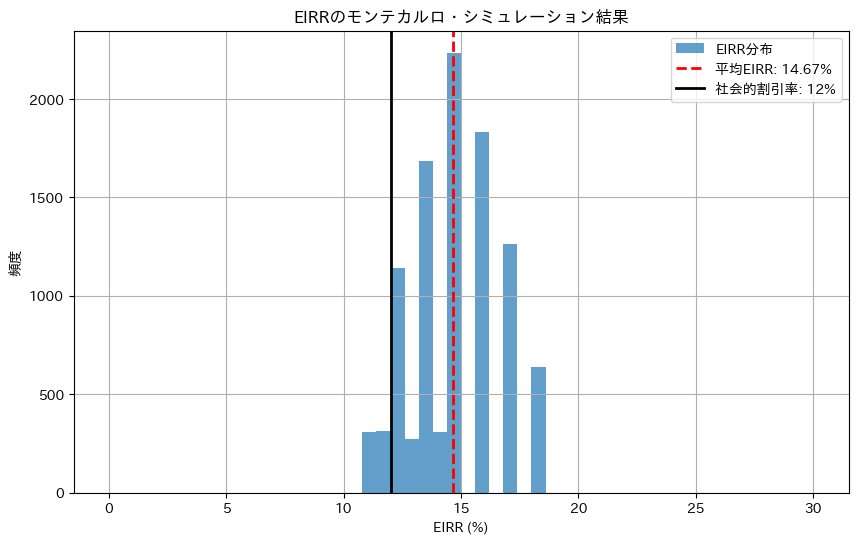

In [2]:
# 必要なライブラリのインストールとインポート
!pip install -q japanize-matplotlib numpy_financial
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
import random
import japanize_matplotlib

# --- 2. 基準ケース（ベースケース）の分析 ---
print("\n--- 基準ケース（ベースケース）の分析結果 ---")
TOTAL_YEARS = CONSTRUCTION_YEARS + LIFESPAN_YEARS

# --- 費用キャッシュフローの作成 ---
costs = np.zeros(TOTAL_YEARS)
costs[0:CONSTRUCTION_YEARS] = TOTAL_CONSTRUCTION_COST / CONSTRUCTION_YEARS
costs[CONSTRUCTION_YEARS:] += OM_COST_ANNUAL
for i in range(1, (LIFESPAN_YEARS // RENEWAL_COST_INTERVAL) + 1):
    year_index = CONSTRUCTION_YEARS + (i * RENEWAL_COST_INTERVAL) - 1
    costs[year_index] += RENEWAL_COST_VALUE

# --- 便益キャッシュフローの作成 ---
benefits = np.zeros(TOTAL_YEARS)
benefits[CONSTRUCTION_YEARS:] = BASE_BENEFIT_ANNUAL

# --- 指標の計算 ---
net_cash_flow = np.insert(benefits - costs, 0, 0)
benefits_pv_stream = np.insert(benefits, 0, 0)
costs_pv_stream = np.insert(costs, 0, 0)
pv_b = npf.npv(SDR, benefits_pv_stream)
pv_c = npf.npv(SDR, costs_pv_stream)
npv_base = pv_b - pv_c
bc_base = pv_b / pv_c
eirr_base = npf.irr(net_cash_flow)

print(f"総便益の現在価値 (PV(B)): {pv_b:,.0f} 万円")
print(f"総費用の現在価値 (PV(C)): {pv_c:,.0f} 万円")
print("-" * 25)
print(f"NPV (B-C): {npv_base:,.0f} 万円")
print(f"B/C (B/C): {bc_base:.2f}")
print(f"EIRR (経済的内部収益率): {eirr_base:.2%}")
print("-" * 40)

# --- 3. モンテカルロ・シミュレーション ---
print("\n--- モンテカルロ・シミュレーションの分析結果 ---")
NUM_SIMULATIONS = 10000
construction_cost_multipliers = [1.0, 1.1, 1.2, 1.3]
renewal_cost_multipliers = [1.0, 1.1, 1.2, 1.3]
benefit_multipliers = [1.0, 1.1, 1.2, 1.3]
eirr_results = []

for _ in range(NUM_SIMULATIONS):
    sim_construction_multiplier = random.choice(construction_cost_multipliers)
    sim_renewal_multiplier = random.choice(renewal_cost_multipliers)
    sim_benefit_multiplier = random.choice(benefit_multipliers)
    sim_costs = np.zeros(TOTAL_YEARS)
    sim_construction_cost_total = TOTAL_CONSTRUCTION_COST * sim_construction_multiplier
    sim_costs[0:CONSTRUCTION_YEARS] = sim_construction_cost_total / CONSTRUCTION_YEARS
    sim_costs[CONSTRUCTION_YEARS:] += OM_COST_ANNUAL
    sim_renewal_cost = RENEWAL_COST_VALUE * sim_renewal_multiplier
    for i in range(1, (LIFESPAN_YEARS // RENEWAL_COST_INTERVAL) + 1):
        year_index = CONSTRUCTION_YEARS + (i * RENEWAL_COST_INTERVAL) - 1
        sim_costs[year_index] += sim_renewal_cost
    sim_benefits = np.zeros(TOTAL_YEARS)
    sim_annual_benefit = BASE_BENEFIT_ANNUAL * sim_benefit_multiplier
    sim_benefits[CONSTRUCTION_YEARS:] = sim_annual_benefit
    sim_net_cash_flow = np.insert(sim_benefits - sim_costs, 0, 0)
    try:
        eirr_results.append(npf.irr(sim_net_cash_flow))
    except:
        eirr_results.append(-1.0)

eirr_results_np = np.array(eirr_results)
print(f"シミュレーション回数: {NUM_SIMULATIONS}回")
print(f"平均EIRR: {np.mean(eirr_results_np):.2%}")
print(f"EIRRが社会的割引率({SDR_PERCENT:.0f}%)を下回る確率: {np.sum(eirr_results_np < SDR) / NUM_SIMULATIONS:.2%}")

# --- グラフ描画 ---
plt.figure(figsize=(10, 6))
eirr_percent_results = eirr_results_np * 100
plt.hist(eirr_percent_results, bins=50, range=(0, 30), alpha=0.7, label='EIRR分布')
plt.axvline(np.mean(eirr_percent_results), color='red', linestyle='dashed', linewidth=2, label=f'平均EIRR: {np.mean(eirr_results_np):.2%}')
plt.axvline(SDR * 100, color='black', linestyle='solid', linewidth=2, label=f'社会的割引率: {SDR_PERCENT:.0f}%')
plt.title('EIRRのモンテカルロ・シミュレーション結果')
plt.xlabel('EIRR (%)')
plt.ylabel('頻度')
plt.legend()
plt.grid(True)
plt.show()